# Local에서 실행하기 위한 code
### Colab을 사용하는 경우를 위해 local에서 쉽게 파일을 압축하고 google drive에 보내기 위한 코드
- map_generator.py, environment.py가 잘 작동하는지 확인
- Source code 파일과 훈련을 재개할 model을 압축하여 google drive에 보내는 코드가 작성되어 있음
- Tensorboard server를 열거나 google drive를 wsl과 mount하는 명령어가 적혀있음 -> 이를 Terminal에 적어서 실행

### Python 파일을 검사하기 위한 사전 설정

In [2]:
# Working directory 수정: 압축할 lg_robot 폴더의 위치
%cd /home/poiuy/lg_robot/

/home/poiuy/lg_robot


In [7]:
# Python 파일 수정 시 자동으로 새로고침
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Python 파일들이 잘 수행되는지 검사

### map_generator.py

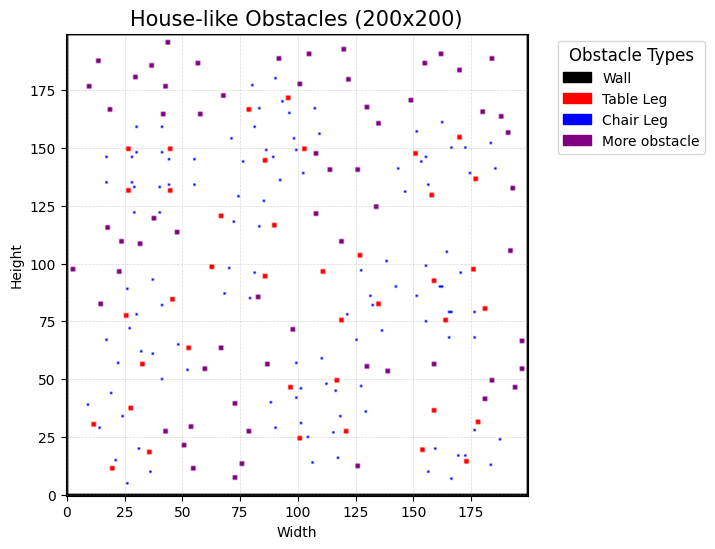

In [3]:
from src.robot_vacuum_redqn.robot_vacuum_redqn.config import EnvConfig, DEFAULT_SEED
from src.robot_vacuum_redqn.robot_vacuum_redqn.map_generator import visualize_house_map

visualize_house_map(seed=DEFAULT_SEED)

### environment.py

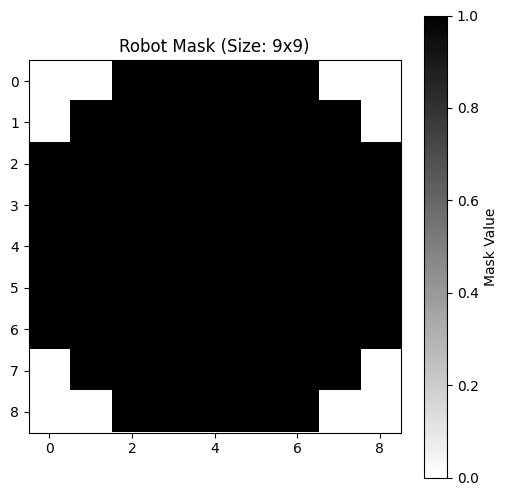

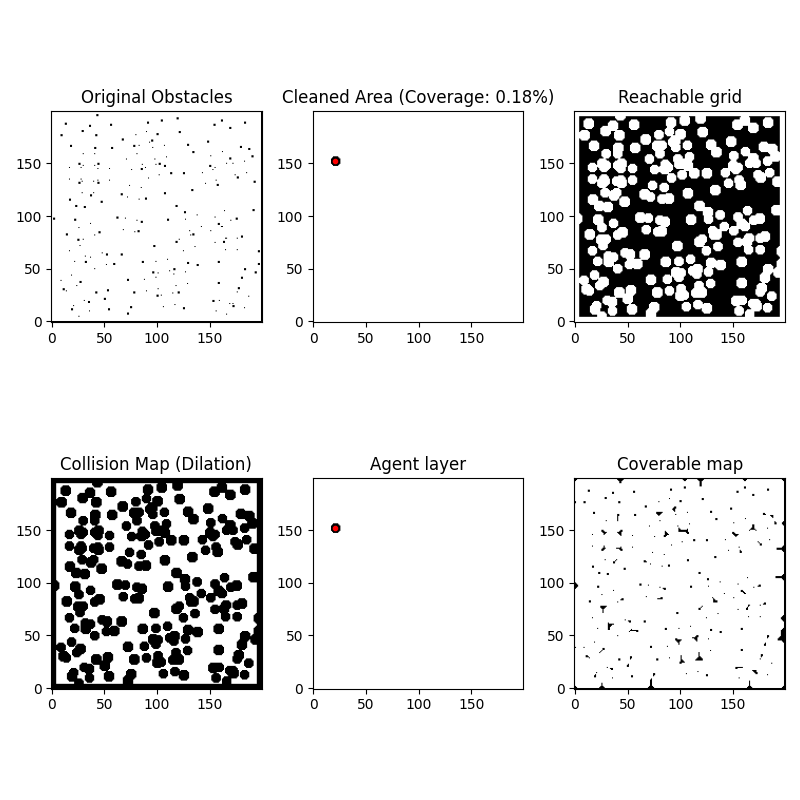

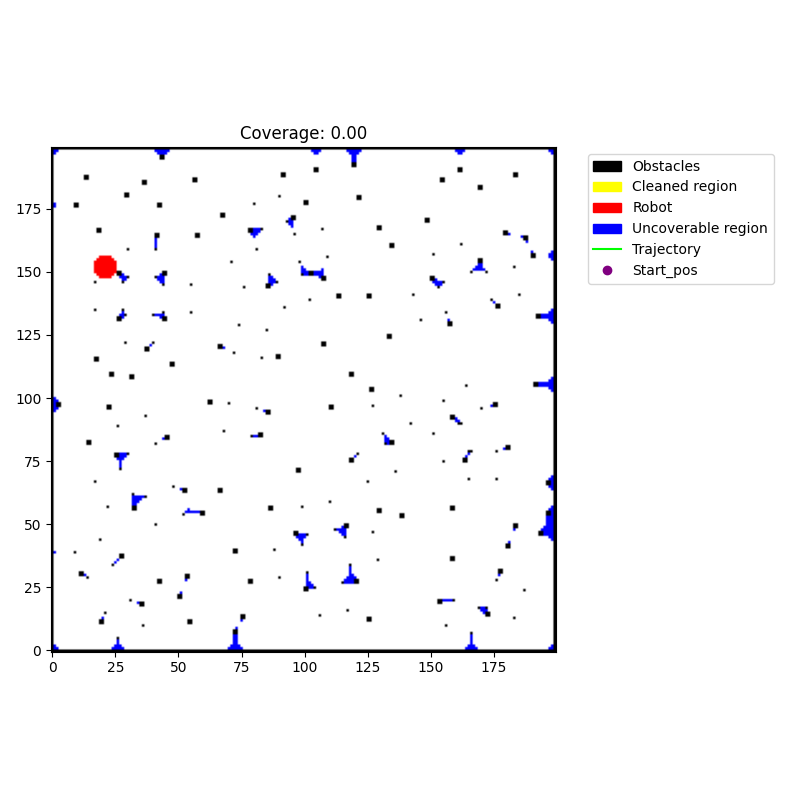

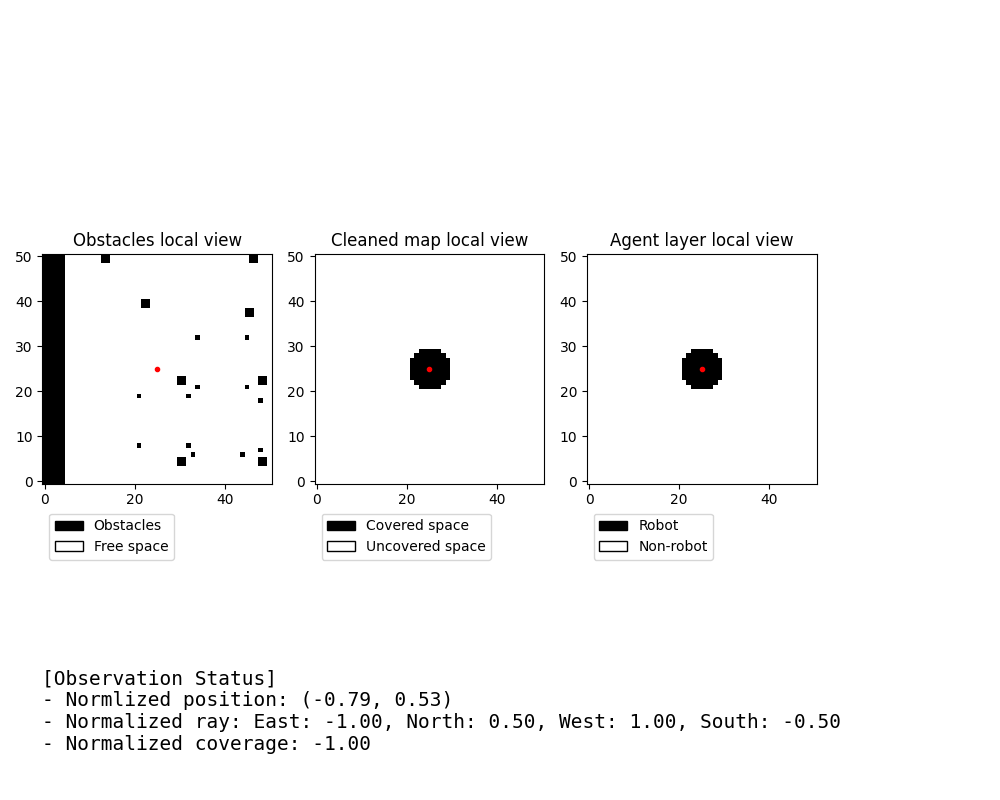

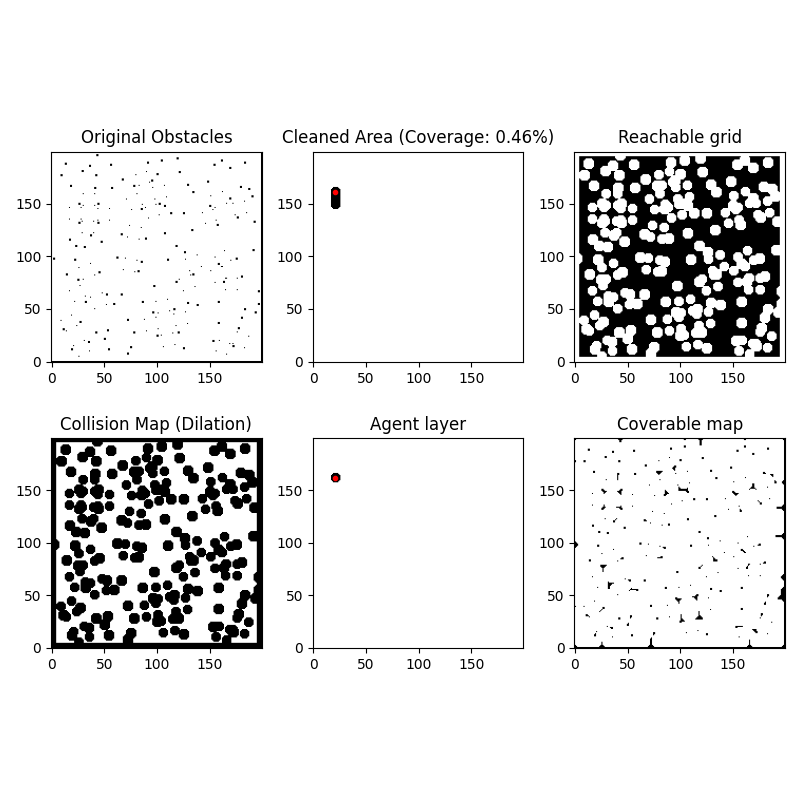

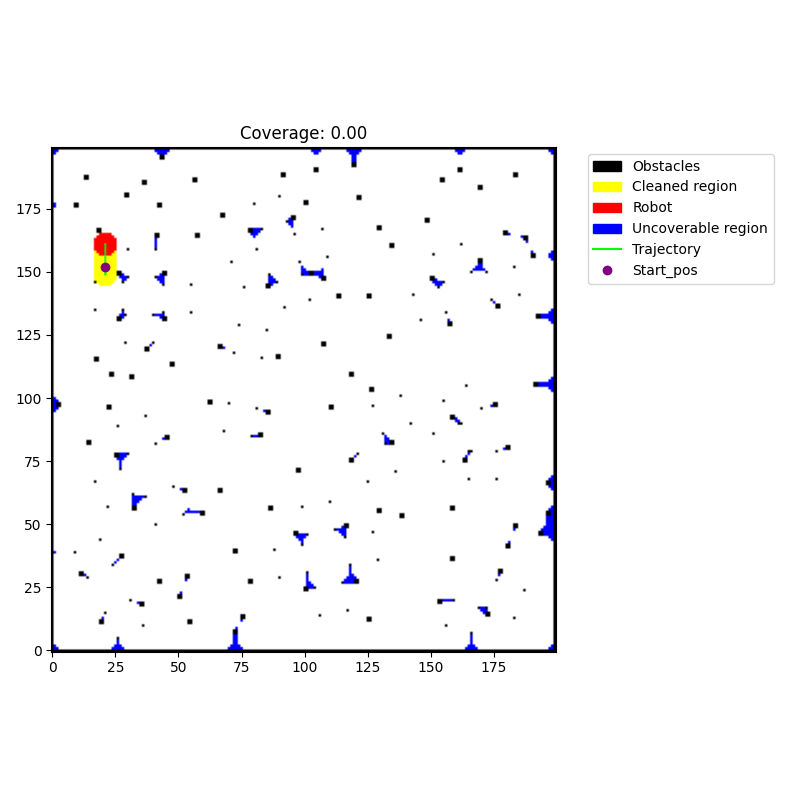

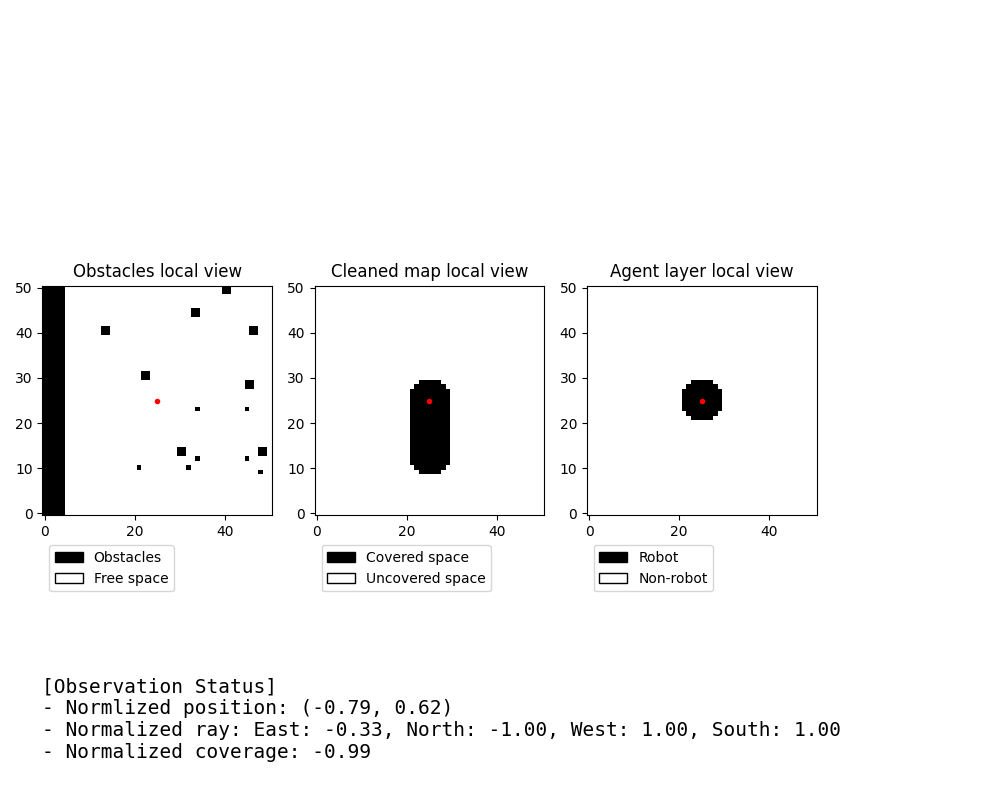

In [7]:
from src.robot_vacuum_redqn.robot_vacuum_redqn.config import EnvConfig, DEFAULT_SEED
from src.robot_vacuum_redqn.robot_vacuum_redqn.environment import get_args, visualize_mask, DQNCoverageEnv
import sys

sys.argv = [" ", # 파일명이 없으므로 sys.argv[0]은 공백으로 처리
            "--robot",
            "--see_map",
            "--see_obs",
            "--debug_reset",
            "--debug_step"]
args = get_args()
cfg = EnvConfig()
env = DQNCoverageEnv(cfg, seed=42)

# 0. Robot visualize
if args.robot:
    visualize_mask(robot_size=env.robot_size)

obs, info = env.reset()
if args.debug_reset:
    if args.see_map:
        # 1. Map visualize: Agent layer, Cleaned layer, Obstacle layer, Collision map, 
        env.show_visualized_img('layer')
        env.show_visualized_img('traj')
    if args.see_obs:
        # 2. observation visualization
        env.show_visualized_img('obs')

if args.debug_step:
    # 3. step() method
    # action_seq = [0]*150 + [1]*3 + [3]*150 + [2]*250 + [3]*100 + [1]*200
    action_seq = [0]*1000 + [3]*1000 + [2]*1000 + [1] * 1000
    for action in action_seq:
        obs, reward, terminated, truncated, info = env.step(action)
    if args.see_map:
        # 1. Map visualize: Agent layer, Cleaned layer, Obstacle layer, Collision map, 
        env.show_visualized_img('layer')
        env.show_visualized_img('traj')
    if args.see_obs:
        # 2. observation visualization
        env.show_visualized_img('obs')

## Colab 또는 GPU 이용 서버를 이용하기 위해 압축 파일 생성 

- 압축 파일을 생성하기 전에 아래 명령어를 terminal에 복사해서 암호를 입력하여 G:와 /mnt/g를 연결

In [ ]:
sudo mkdir -p /mnt/g && sudo mount -t drvfs G: /mnt/g

- /mnt/g에 구글 드라이브에 올릴 파일을 옮기면 구글 드라이브에 파일이 업로드 됨.
- 압축 파일은 ~/lg_robot 폴더에 생성되고 이를 구글 드라이브에 복사함
- 압축 파일이 원하는대로 생성되었는지 확인하고 싶으면 local에서 압축 파일을 해제하고 그 내용물을 확인함.
- 압축 파일이 구글 드라이브에 존재하는 것을 확인하면 local에 있는 압축 파일을 제거함.

### 압축 파일 생성

In [3]:
# 파일을 google drive에 쉽게 올리기 위해 압축하기 위한 코드
# 필요한 파일들만 골라서 압축

import zipfile
import os

def create_custom_project_zip(base_path, src_rel_dir, model_setting, output_zip_name):
    """
    base_path: 최상위 폴더 경로 (예: 'LG_ROBOT')
    include_paths: 압축에 포함할 하위 경로 리스트
    output_zip_name: 생성될 압축 파일 이름
    """
    ############# src에 있는 폴더 중 압축하지 않을 파일을 선정 #############
    exclude_folders_in_srcdir = {'__pycache__', 'logs', 'models'}
    ###################################################################
    
    with zipfile.ZipFile(output_zip_name, 'w', zipfile.ZIP_DEFLATED) as project_zip:
        
        # source code를 압축파일에 추가
        src_abs_dir = os.path.join(base_path, src_rel_dir) # source code가 담긴 폴더 경로
        if os.path.isdir(src_abs_dir):
            for root, dirs, files in os.walk(src_abs_dir):
                
                # dirs에서 탐색하지 않으려는 폴더들을 제외하여 src code만 압축 파일에 저장
                dirs[:] = [d for d in dirs if d not in exclude_folders_in_srcdir]
                
                for src_file in files:
                    src_file_abs_path = os.path.join(root, src_file) # 각 source code의 절대 경로
                    arcname = os.path.relpath(src_file_abs_path, os.path.dirname(base_path)) # zip 파일의 구조를 맞추기 위한 상대 경로
                    project_zip.write(src_file_abs_path, arcname)
                    
        # model file을 압축파일에 추가
        model_rel_dir = model_setting['Model_folder']
        model_abs_dir = os.path.join(base_path, model_rel_dir) # models이 담긴 폴더 경로 
        if os.path.isdir(model_abs_dir):
            
            # Model file을 압축
            model_list = model_setting['Include_models']
            if len(model_list) > 0:
                for model_file in model_list:
                    model_file_abs_path = os.path.join(model_abs_dir, model_file)
                    if os.path.isfile(model_file_abs_path):
                        arcname = os.path.relpath(model_file_abs_path, os.path.dirname(base_path))
                        project_zip.write(model_file_abs_path, arcname)
            
            # Checkpoint 중에 최신 checkpoint를 압축
            checkpoint_list = model_setting['Include_checkpoints']
            if len(checkpoint_list) > 0:
                for checkpnt_fld in checkpoint_list:
                    checkpnt_fld += "_checkpoints" # Checkpoint 폴더 이름
                    checkpnt_fld_abs_path = os.path.join(model_abs_dir, checkpnt_fld)
                    if os.path.isdir(checkpnt_fld_abs_path):
                        all_chkpnt_files = [os.path.join(checkpnt_fld_abs_path, f) for f in os.listdir(checkpnt_fld_abs_path)] # Checkpoint 전체
                        if all_chkpnt_files:
                            latest_file = max(all_chkpnt_files, key=os.path.getmtime) # 최신 파일을 고름
                            arcname = os.path.relpath(latest_file, os.path.dirname(base_path))
                            project_zip.write(latest_file, arcname)

PROJECT_ROOT = os.getcwd() # 최상위 프로젝트 폴더 경로
SOURCE_CODE_FOLDER = "src/robot_vacuum_redqn/robot_vacuum_redqn" # Source code 폴더

############# 저장할 model을 설정하기 위한 코드: 사용자 설정 가능 #############
# Model을 받기 위한 설정
MODEL_FOLDER = "src/robot_vacuum_redqn/robot_vacuum_redqn/models" # Model 폴더
INCLUDE_MODELS = ["one_map_model.pth"] # models 폴더에 넣고 싶은 model 파일 목록
INCLUDE_CHECKPOINTS = ["one_map_model_-2.0"] # models 폴더에 넣고 싶은 checkpoint 목록 (이름에서 _checkpoints는 쓰지 않고 모델 이름만 씀)
#########################################################################

# 압축파일 이름
ZIP_NAME = "lg_robot_forColab.zip"

# Local에 저장할 경로 설정
LOCAL_OUTPUT_NAME = os.path.join(PROJECT_ROOT, ZIP_NAME)

# 구글 드라이브에 저장할 경로 설정
GDRIVE_PATH = "/mnt/g/내 드라이브" # WSL에서 인식한 구글 드라이브 한글 경로
target_dir = os.path.join(GDRIVE_PATH, "Colab_Uploads") # 구글 드라이브에 업로드할 폴더를 생성
if not os.path.exists(target_dir):
    os.makedirs(target_dir, exist_ok=True)
    print(f"폴더 생성 완료: {target_dir}")
GDRIVE_OUTPUT_NAME = os.path.join(target_dir, ZIP_NAME) # 업로드 경로 설정

model_setting = {
    "Model_folder": MODEL_FOLDER,
    "Include_models": INCLUDE_MODELS,
    "Include_checkpoints": INCLUDE_CHECKPOINTS,
}

# 실행
create_custom_project_zip(PROJECT_ROOT, SOURCE_CODE_FOLDER, model_setting, LOCAL_OUTPUT_NAME)
print(f"압축 완료: {os.path.join(LOCAL_OUTPUT_NAME)}")

# 구글 드라이브에 복사
!cp "{LOCAL_OUTPUT_NAME}" "{GDRIVE_OUTPUT_NAME}"

압축 완료: /home/poiuy/lg_robot/lg_robot_forColab.zip


In [4]:
# 압축 파일을 해제하고 코드를 실행할 for_colab.ipynb를 drive에 복사
# 드라이브에서 이 파일을 열어서 사용
import os

notebook_src_path = os.path.join(PROJECT_ROOT, SOURCE_CODE_FOLDER, "for_colab.ipynb")
notebook_src_dest = os.path.join("/mnt/g/내 드라이브/Colab_Uploads/", "for_colab.ipynb")
!cp "{notebook_src_path}" "{notebook_src_dest}"

In [ ]:
# 압축 파일이 잘 압축되었는지 확인하기 위한 코드: /lg_robot 폴더에 압축 해제
import zipfile
import os

try: 
    with zipfile.ZipFile(LOCAL_OUTPUT_NAME, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(LOCAL_OUTPUT_NAME))
except FileNotFoundError:
    print(f"{LOCAL_OUTPUT_NAME} 파일이 존재하지 않습니다.")
except Exception as e:
    print(f"압축 해제 중 오류 발생: {e}")

In [5]:
# 압축파일이 구글 드라이브에 잘 복사 되었는지 확인
!ls "/mnt/g/내 드라이브/Colab_Uploads"

for_colab.ipynb  lg_robot_forColab.zip


In [6]:
# 압축 파일이 구글 드라이브에 존재하면 local에 있는 압축 파일을 삭제
!rm "{LOCAL_OUTPUT_NAME}"

## TensorBoard 서버 열기
- Terminal을 열어서 아래 명령어를 입력하여 훈련 현황을 볼 수 있도록 함.
- 구글 드라이브에 있는 logs file에 접근하여 tensorboard를 출력함

In [ ]:
tensorboard --logdir="/mnt/g/내 드라이브/Colab_Uploads/lg_robot/src/robot_vacuum_redqn/robot_vacuum_redqn/logs"

- /mnt/g/에 tensorboard update이 잘 일어나지 않으면 구글 드라이브에서 직접 tensorboard 파일을 가져와서 local에 저장
- local에 저장한 tensorboard 파일을 서버에 전송하기 위해 아래 명령어를 terminal에 입력

In [ ]:
tensorboard --logdir="/home/poiuy/lg_robot/src/robot_vacuum_redqn/robot_vacuum_redqn/logs"

### Local에서 파일 실행

------------------------------
  [System Configuration]
  > Device: CPU
------------------------------


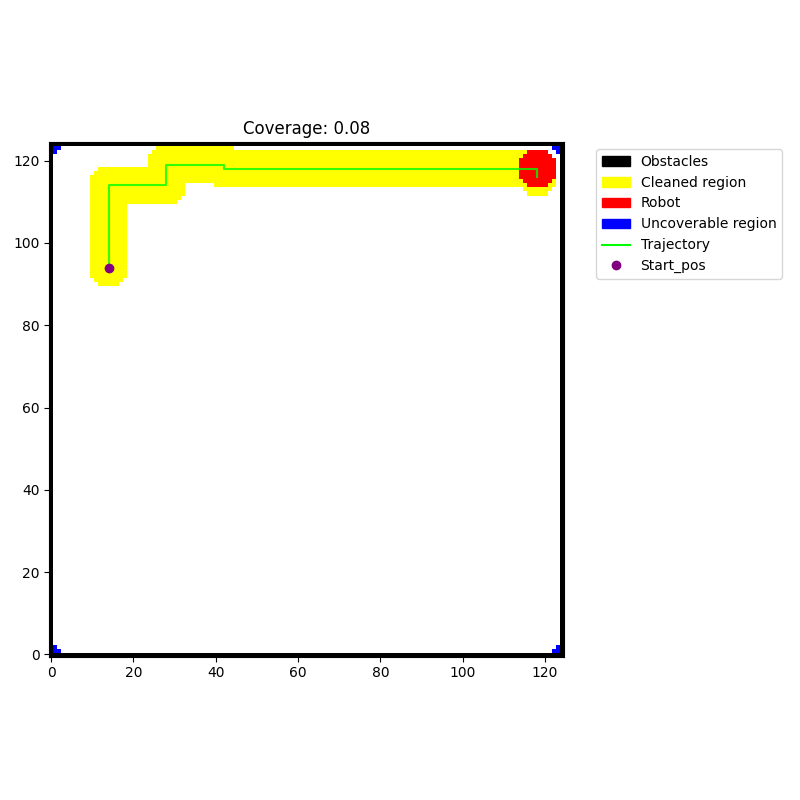

Test finished. Coverage: 0.08209300787193226


In [9]:
from src.robot_vacuum_redqn.robot_vacuum_redqn.main import main
import sys

args_str = """
    --mode test
    --model_name No_obstacle_model_1.pth
    --optimizer sgd
    --batch_size 128
    --gamma 0.99
    --lr 1e-4
    --momentum 0.9
    --buffer_size 50000
    --warmup_episodes 5
    --warmup_ep_steps 1000
    --warmup_tot_steps 5000
    --target_update 1000
    --policy_update 1
    --valid_freq 30
    --ckp_freq 10
    --valid_map_num 1
    --valid_start_point_num 5
    --max_episodes 30000
    --epsilon_start 1.0
    --epsilon_end 0.1
    --epsilon_decay 100000
    --use_softmax
    --softmax_temp 1.0
    --do_normalize
    --use_wandb
    --reset_only_start_pos
    --map_height 500.0
    --map_width 500.0
    --num_tables 0
    --uncleaned_reward 0.05
    --cleaned_penalty -0.01
    --obstacle_penalty -1.0
    --small_obs_num_per_window_max 0
    --small_obs_num_per_window_min 0
"""

sys.argv = [" "] + args_str.split()

# Training
main()